In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy


In [15]:
## B-spline class

class Bspline():
    
    def __init__(self, order, knots):
        
        self.knots = tf.constant(knots, dtype = tf.float32)
        self.order = order
        self.degree = order - 1
        self.num_params = len(knots) + order
        
    def bspline_basis(self, x, k, i, t):
        """
        B-spline basis function value B(j,n) at x.
        
        Input arguments:
         x:
            value where the basis function is to be evaluated
         n:
            B-spline order (2 for linear, 1 for quadratic, etc.)
         i:
            interval index, 0 =< j < numel(t)-k-1

         t:
            knot vector

         Output arguments:
         y:
        
        """
        if k == 0:

            return 1.0 if t[i] <= x < t[i+1] else 0.0

        if t[i+k] == t[i]:

            c1 = 0.0 #indeterminate forms 0/0 are deemed to be zero

        else:
            
            c1 = (x - t[i])/(t[i+k] - t[i]) * self.bspline_basis(x, k-1, i, t)

        if t[i+k+1] == t[i+1]:

            c2 = 0.0 #indeterminate forms 0/0 are deemed to be zero

        else:

            c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * self.bspline_basis(x, k-1, i+1, t)
        
        return c1 + c2
    
    def basis_matrix(self, x):
        """
        B-spline basis function value matrix B(n) for x.
        
        Input arguments:
         n:
            B-spline order (2 for linear, 3 for quadratic, etc.)
         t:
            knot vector
         x (optional):
            an m-dimensional vector of values where the basis function is to be
            evaluated
        
        Output arguments:
         B:
            a matrix of m rows and numel(t)-n columns
        """
        n = self.order
        t = self.knots
        k = n-1
        
        B = np.zeros((len(x),len(t) - n))
        
        for i in range(len(t) - n):
            for j in range(len(x)):
                B[j,i] = self.bspline_basis(x[j], k, i, t)
            
        return tf.constant(B, dtype = tf.float32)      
        
    def fit(self, x_data, y_data):
        
        x_data = tf.constant(x_data, dtype = tf.float32)
        y_data = tf.constant(y_data, dtype = tf.float32)
        
        Bmat =  self.basis_matrix(x_data)
        
        #Solve least squares y = B * c
        self.coeffs = tf.linalg.lstsq(Bmat, y_data)
    
    def predict(self, x_pred, coeffs = None):
        
        if coeffs is None:
            coeffs = self.coeffs
        
        x_pred = tf.constant(x_pred, dtype = tf.float32)
        coeffs = tf.constant(coeffs, dtype = tf.float32)
        
        Bmat =  self.basis_matrix(x_pred)
        
        y_pred = tf.matmul(Bmat, coeffs)
        
        return y_pred

In [16]:
from itertools import chain, combinations
from itertools import combinations_with_replacement as combinations_w_r
from math import comb

class DynamicsBasis():
    
    def __init__(self, degree, X, t):  
#         super().__init__(degree = degree)
        self.m_samples = X.shape[0]
        self.dim = X.shape[1]
        self.degree = degree
        self.n_basis = comb(self.dim + self.degree, self.degree)
        self.t = t
        self.include_bias = True
        self.X = tf.constant(X, dtype = tf.float32)
        
    @property
    def multi_index(self):
        
        comb = combinations_w_r
        start = int(not self.include_bias)
        combinations = chain.from_iterable(comb(range(self.dim), i) for i in range(start, self.degree + 1))
                                   
        
        return tf.cast(tf.stack([tf.math.bincount(c, minlength=self.dim) for c in combinations], axis = 0), dtype = tf.float32)
                                    
    @property
    def basis_names(self, input_dims = None):
        
        powers = self.multi_index.numpy()
        if input_dims is None:
            input_dims = ['x%d' % i for i in range(powers.shape[1])]
        basis_names = []
        for row in powers:
            inds = np.where(row)[0]
            if len(inds):
                name = " ".join("%s^%d" % (input_dims[ind], exp)
                                if exp != 1 else input_dims[ind]
                                for ind, exp in zip(inds, row[inds]))
            else:
                name = "1"
            basis_names.append(name)
            
        return basis_names
    
    def phi_matrix(self, X = None):
        
        if X is None:
            X = self.X
        else:
            X = tf.constant(X, dtype = tf.float32)
            
        
        powers = self.multi_index
        
        Phi = tf.zeros((X.shape[0], self.n_basis))
        
#         idx_arr = np.zeros((X.shape[0],2))
#         idx_arr[:,0] = [i for i in range(X.shape[0])]
        
#         for basis in range(self.n_basis):
            
#             idx_arr[:,1] = basis
#             indices = tf.convert_to_tensor(idx_arr, dtype = tf.int32)
#             print(indices)
#             updates = tf.reduce_prod(tf.pow(X, tf.tile([powers[basis,:]],[X.shape[0],1])), axis = 1)
#             print(updates)
#             tf.tensor_scatter_nd_update(Phi, indices, updates)

        for basis in range(self.n_basis):
        
            indices = tf.constant([basis])
            col_indices_nd = tf.stack(tf.meshgrid(tf.range(tf.shape(Phi)[0]), indices, indexing='ij'), axis=-1)
            updates = tf.reshape(tf.reduce_prod(tf.pow(X, tf.tile([powers[basis,:]],[X.shape[0],1])), axis = 1), (X.shape[0],1))
            temp = tf.scatter_nd(col_indices_nd, updates, (X.shape[0], self.n_basis))
            Phi = tf.add(Phi, temp)
            
        return Phi
        
    def psi_matrix(self, X=None, t=None):
        
        if X is None:
            X = self.X
        else:
            X = tf.constant(X, dtype = tf.float32)
            
        if t is None:
            t = self.t
        else:
            t = tf.constant(t, dtype = tf.float32)
        
        Dt = t[1] - t[0]
        
        T = tf.convert_to_tensor(Dt * np.tril(np.ones(self.m_samples)), dtype = tf.float32)
        
        Phi = self.phi_matrix(X)
                
        return tf.matmul(T, Phi)

InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid. [Op:Cholesky]

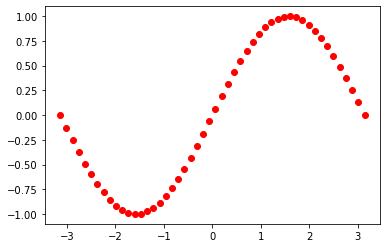

In [18]:
x_data = np.linspace(-np.pi, np.pi, 50)
x_pred = np.linspace(-np.pi, np.pi, 200)
y_data = np.sin(x_data)
knots = np.concatenate(([x_data[0]]*3, x_data, [x_data[-1]]*3))

plt.plot(x_data, y_data, 'ro')

degree = 3
order = degree + 1

bs = Bspline(order, knots)

bs.fit(x_data, y_data)
y_pred = bs.predict(x_pred).numpy()

plt.plot(x_pred, y_pred,'b')

In [ ]:
class SRSplineIdentification():
    
    def __init__(self, X, t, poly_degree, spline_order):
        
        self.Y_data = X.flatten()
        self.t = t
        self.m_samples = X.shape[0]
        self.dim = X.shape[1]
        knots = np.concatenate([t[0]*np.ones(3), t, t[-1]*np.ones(3)])
        self.bspline = Bspline(spline_order, knots)#Initialize bspline object
        
        self.spline_matrix = tnp.kron(np.eye(self.dim), self.bspline.basis_matrix(t))
        self.t_half = 0.5 * (t[1:-1] + t[0:-2])
        self.spline_matrix_half = tnp.kron(tnp.eye(self.dim), self.bspline.basis_matrix(self.t_half))
        self.dyn_basis = DynamicsBasis(poly_degree, X)#Initialize dynamics basis object
        
        self.parameters = self.initialize_parameters()
        
        self.eps = 1e-4
        self.alpha = 1e-1
        self.lambd = 1e-3

        
    def initialize_parameters(self):
        
        self.xi = tf.constant(np.random.rand(self.dyn_basis.num_params, self.dim).flatten(), dtype = tf.float32)
        self.theta = tf.constant(np.random.rand(self.bspline.num_params, self.dim).flatten(), dtype = tf.float32)
        
        return tf.concat([self.xi, self.theta], axis = 0)
    
    def spline_predict(self, mode):
        
        if mode == 0:
            return tf.matmul(self.spline_matrix, self.theta)
        else:
            print(self.spline_matrix_half)
            return tf.matmul(self.spline_matrix_half, self.theta)
        
    def spline_residual(self):
        
        Y_pred = self.spline_predict(0)
                        
        return self.Y_data - Y_pred
        
    def dynamics_residual(self):
        
        Y_tilde = self.Y_data[1:-1]
        
        Y_pred = self.spline_predict(1)
        
        psi_mat = self.dyn_basis.psi_matrix(self.t_half, Y_pred)
        
        D_big = np.kron(np.eye(self.dim), psi_mat)
                
        return Y_tilde - tf.matmul(D_big,self.xi)
        
    def l1_residual(self):
        
        W = tf.linalg.diag(1 / tf.abs(self.xi) + self.eps * tf.ones(len(xi)))
        L = tf.sqrt(W);
        
        return  tf.matmul(L, self.xi)
    
    def residual_vec(self):
        
        return tf.concat([self.dynamics_residual(), tf.sqrt(self.alpha) * self.spline_residual(),
                          tf.sqrt(self.lambd) * self.l1_residual()], axis = 0)
        
    def loss(self):
        
        return 0.5 * tf.reduce_sum(tf.square(self.residual_vec()))
        
    def get_jacobian(self):
        
        with tf.GradientTape(persistent = True) as tape:
            
            tape.watch(self.parameters)
            
            res_vec = self.residual_vec()
            
        jac = tape.jacobian(res_vec, self.parameters)
        
        del tape
        
        return jac            
        
    def get_gradient(self):
        
        with tf.GradientTape(persistent = True) as tape:
            
            tape.watch(self.parameters)
            
            loss_value = self.loss()
            
        grad = tape.gradient(loss_value, self.parameters)
        
        del tape
        
        return grad
        
    def train_step(self):
        pass
    
    def train(self):
        pass
        


In [7]:
from itertools import chain, combinations
from itertools import combinations_with_replacement as combinations_w_r
from math import comb

X = tf.random.uniform((10,2), dtype = tf.float32)
t = tf.linspace(0,1,100)
degree = 3
dim = 2
n_basis = comb(dim+degree, degree)
include_bias = True

comb = combinations_w_r
start = int(not include_bias)
combinations = chain.from_iterable(comb(range(dim), i) for i in range(start, degree + 1))
mi = tf.cast(tf.stack([tf.math.bincount(c, minlength=dim) for c in combinations], axis = 0), dtype = tf.float32)

In [8]:
Phi = tf.constant(tf.zeros((X.shape[0], n_basis), dtype=tf.float32))
        
for basis in range(n_basis):
        repeat(mi[basis,:], repeats=[X.shape[0]], axis=0)

        tf.tensor_scatter_nd_update(Phi, [i,basis], [tf.reduce_prod(tf.pow(X[i,:], mi[basis,:]))])


NameError: name 'repeat' is not defined

In [85]:
tensor = tf.zeros([6, 3], dtype=tf.float32)
tensor

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)>

In [98]:
indices = tf.convert_to_tensor(np.array([[2], [4]]), dtype = tf.int32)     # num_updates == 2, index_depth == 1
num_updates, index_depth = indices.shape.as_list()
indices

<tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[2],
       [4]], dtype=int32)>

In [99]:
indices.shape

TensorShape([2, 1])

In [100]:
outer_shape = tensor.shape[:index_depth]
inner_shape = tensor.shape[index_depth:]


In [101]:
updates = tf.constant([[1, 2, 3],
                       [4, 5, 6]], dtype = tf.float32)


In [102]:
tf.tensor_scatter_nd_update(tensor, indices, updates).numpy()


array([[0., 0., 0.],
       [0., 0., 0.],
       [1., 2., 3.],
       [0., 0., 0.],
       [4., 5., 6.],
       [0., 0., 0.]], dtype=float32)

In [53]:
var = tf.Variable(np.random.rand(5,3))
print(var)
# update the last column of the three (3x3) matrices to random integer values
# note that the update values needs to have the same shape
# as broadcasting is not supported as of TF2
var[:,1].assign(np.random.randint(10,size=(5,)))
print(var)

<tf.Variable 'Variable:0' shape=(5, 3) dtype=float64, numpy=
array([[0.10046628, 0.05025532, 0.52576539],
       [0.49725771, 0.12149373, 0.65674228],
       [0.49472537, 0.42323952, 0.95295847],
       [0.08648505, 0.81362259, 0.48778956],
       [0.69626064, 0.37134397, 0.13123187]])>
<tf.Variable 'Variable:0' shape=(5, 3) dtype=float64, numpy=
array([[0.10046628, 9.        , 0.52576539],
       [0.49725771, 7.        , 0.65674228],
       [0.49472537, 2.        , 0.95295847],
       [0.08648505, 1.        , 0.48778956],
       [0.69626064, 9.        , 0.13123187]])>
